### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

### read csv

In [13]:
df = pd.read_csv("Data/sales_24mo_date_agg_20230630T181821.csv")
#df = pd.read_csv("Data/example_sales.csv")

df_Ni = df.loc[df["country"] == "Nigeria"]
df_Ke = df.loc[df["country"] == "Kenya"]

df.head()

,location_id,name_of_pharmacy,market,country,product,usd_price,sl_sold
0,"""00536e83-d249-461b-b4ae-979ef215e813""",Neolite Pharmaceuticals,Nairobi,Kenya,ABZ Suspension 400mg/10ml,0.24800,473
1,"""00536e83-d249-461b-b4ae-979ef215e813""",Neolite Pharmaceuticals,Nairobi,Kenya,ABZ Tablets 400mg x 1,0.19200,549
2,"""00536e83-d249-461b-b4ae-979ef215e813""",Neolite Pharmaceuticals,Nairobi,Kenya,ATM Suspension 15ml,1.19485,43
3,"""00536e83-d249-461b-b4ae-979ef215e813""",Neolite Pharmaceuticals,Nairobi,Kenya,Betapyn Tablets x 18,2.96000,12
4,"""00536e83-d249-461b-b4ae-979ef215e813""",Neolite Pharmaceuticals,Nairobi,Kenya,Calpol Infant Suspension 100ml,2.23200,10


### compute S(L, D), S(L), s(L, D)

In [14]:
## after extracting S(L, D) from df_, we ditch df_ and work only with these dicts

## S(L, D) and loc_prods(L), set of products sold at each L
S = {}
loc_prods = {}
for _, row in df_Ni.iterrows():
    if row["sl_sold"] != 0:
        if row["location_id"] in S:
            S[row["location_id"]][row["product"]] = row["sl_sold"] * row["usd_price"]
            loc_prods[row["location_id"]].add(row["product"])
        else:
            S[row["location_id"]] = {row["product"]: row["sl_sold"] * row["usd_price"]}
            loc_prods[row["location_id"]] = {row["product"]}

## S(L) and loc_n_prods(L), number of distinct products at each L
loc_sales = {loc: sum(S_loc_prods.values()) for loc, S_loc_prods in S.items()}
loc_n_prods = {loc: len(loc_prods_num) for loc, loc_prods_num in loc_prods.items()}

## the list of locations doesn't include zero-sales locations
locs = list(loc_sales.keys())

## set of all products with nonzero sales in at least one loc
## and set of products with nonzero sales at each loc
prods = set()
prods_sold_at_loc = {}
for loc, S_loc_prods in S.items():
    prods_sold_at_loc[loc] = set(S_loc_prods.keys())
    prods.update(S_loc_prods.keys())

## assign S(L, D) = 0 for all current nonexistent S[L][D]
for S_loc_prods in S.values():
    for prod in prods:
        if prod not in S_loc_prods:
            S_loc_prods[prod] = 0

## s(L, D)
s = {}
for loc, S_loc_prods in S.items():
    s[loc] = {prod: S[loc][prod] / loc_sales[loc] for prod, S_val in S_loc_prods.items()}

### number of distinct products sold per location

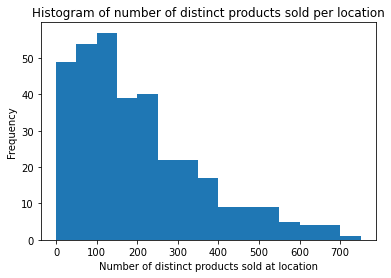

Average number of distinct products sold at location: 202.30791788856305
Median number of distinct products sold at location: 166.0


In [18]:
## visualization
plt.hist(loc_n_prods.values(), bins = np.arange(0, 751, 50))
plt.title("Histogram of number of distinct products sold per location")
plt.xlabel("Number of distinct products sold at location")
plt.ylabel("Frequency")
plt.show()
print("Average number of distinct products sold at location: " + str(np.mean(tuple(loc_n_prods.values()))))
print("Median number of distinct products sold at location: " + str(np.median(tuple(loc_n_prods.values()))))

### fraction of locations which sell each product

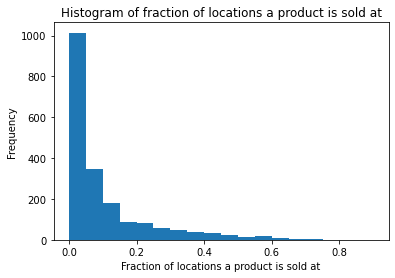

Number of distinct products with nonzero sales: 1956
Average fraction of locations a product is sold at: 0.10342940587349796


In [5]:
## fraction of locations which sell each product
n_locs = len(locs)
freq = {}
for loc, prods_at_loc in loc_prods.items():
    for prod in prods_at_loc:
        if prod not in freq:
            freq[prod] = 1 / n_locs
        else:
            freq[prod] += 1 / n_locs

## visualization
plt.hist(freq.values(), bins = np.linspace(0, 0.9, 19))
plt.title("Histogram of fraction of locations a product is sold at")
plt.xlabel("Fraction of locations a product is sold at")
plt.ylabel("Frequency")
plt.show()
print("Number of distinct products with nonzero sales: " + str(len(freq)))
print("Average fraction of locations a product is sold at: " + str(np.mean(np.array(tuple(freq.values())))))

### calculate average number of distinct products sold per location, as k should be within this ballpark

In [6]:
print("Average number of distinct products sold per location = " + str(sum(freq.values())))

Average number of distinct products sold per location = 202.307917888562


### computing curly_D[p], subset of products which sell in at least fraction p of locations

In [7]:
def compute_curly_D(p_range, to_print = False):
## computing curly_D[p]
    curly_D = {}
    for p in p_range:
        curly_D[p] = set([prod for prod in freq.keys() if freq[prod] >= p])
        if to_print:
            print("|curly_D_[p = {}]| = ".format(p) + str(len(curly_D[p])))

    return curly_D

### step 1: compute pairwise location similarity V_p(L1, L2)

In [8]:
def compute_Vp(sim_fn, p, curly_D, to_visualize = True, n_viz = 3):
## computing V_p, only using products D in curly_D[p]
    Vp = {loc: {} for loc in locs}
    for i in range(len(locs)):
        loc1 = locs[i]
        Vp[loc1][loc1] = 0
        for j in range(i + 1, len(locs)):
            loc2 = locs[j]
            if sim_fn == "1a":
                Vp[loc1][loc2] = 1 / sum([abs(s[loc1][D] - s[loc2][D])\
                                   for D in curly_D[p]])
            Vp[loc2][loc1] = Vp[loc1][loc2]
            #Vp[loc1][loc2] = - math.sqrt(sum([(s[loc1][D] - s[loc2][D])\
            #                        ** 2 for D in curly_D[p]]))
            #Vp[loc1][loc2] = -sum([(s[loc1][D] - s[loc2][D]) ** 2\
            #                       for D in curly_D[p]])

    if to_visualize:
        print("\nSimilarity histogram examples")
        for i in range(n_viz):
            plt.hist(Vp[locs[i]].values())
            plt.title("Similarities of location {} to other locations".format(i) + ", p = " + str(p))
            plt.xlabel("V_p(L, L_{})".format(i))
            plt.ylabel("Frequency")
            plt.show()

    return Vp

### step 2: calculate product ratings R(L, D)

In [9]:
def compute_R(rating_fn, Vp):
    R = {}
    for loc0 in S:
        if rating_fn == "2a":
            R[loc0] = {prod: sum([Vp[loc0][loc] * S[loc][prod] for loc in locs]) for prod in prods}

    return R

### step 3: recommend k top-rated products for each location

In [10]:
def compute_recs(k, R):
    recs = {}
    for loc in locs:
        recs[loc] = sorted(R[loc].items(), key = lambda x: x[1], reverse = True)
        recs[loc] = set([item[0] for item in recs[loc][:k]])
    #print(recs[locs[0]])

    return recs

### step 4: evaluation: calculate recall and precision

In [11]:
def calc_metrics(recs, p, k, sim_fn, rating_fn):
    recall = {}
    precision = {}
    null_precision = {}
    for loc in locs:
        tp = len(recs[loc].intersection(prods_sold_at_loc[loc]))
        recall[loc] = tp / len(prods_sold_at_loc[loc])
        precision[loc] = tp / k
        null_precision[loc] = len(prods_sold_at_loc[loc]) / len(prods)

    avg_recall = sum(recall.values()) / n_locs
    avg_precision = sum(precision.values()) / n_locs

    null_recall = k / len(prods)
    avg_null_precision = sum(null_precision.values()) / n_locs

    ## visualization
    plt.hist(recall.values(), bins = np.linspace(0, 1, 21))
    plt.title("Histogram of recall at all locations (p = " + str(p)\
              + ", k = " + str(k) + ", " + sim_fn + ", " + rating_fn + ")")
    plt.xlabel("Recall value")
    plt.ylabel("Frequency")
    plt.show()
    print("Average recall = " + str(avg_recall))

    plt.hist(precision.values(), bins = np.linspace(0, 1, 21))
    plt.title("Histogram of precision at all locations (p = " + str(p)\
              + ", k = " + str(k) + ", " + sim_fn + ", " + rating_fn + ")")
    plt.xlabel("Precision value")
    plt.ylabel("Frequency")
    plt.show()
    print("Average precision = " + str(avg_precision))

    return avg_recall, avg_precision

### full location-based filtering algorithm

In [12]:
def location_based_filter(p_range, k_range, sim_fn, rating_fn):
    curly_D = compute_curly_D(p_range)
    recalls = {p: {} for p in p_range}
    precisions = {p: {} for p in p_range}
#    for p in p_range:
#        print("\np = " + str(p))
#        Vp = compute_Vp(sim_fn, p, curly_D)
#        R = compute_R(rating_fn, Vp)
#        for k in k_range:
#            print("\np = " + str(p) + ", k = " + str(k))
#            recs = compute_recs(k, R)
#            recalls[p][k], precisions[p][k] = calc_metrics(recs, p, k, sim_fn, rating_fn)
    for p, k in zip(p_range, k_range):
        print("\np = " + str(p) + ", k = " + str(k))
        Vp = compute_Vp(sim_fn, p, curly_D, to_visualize = False)
        R = compute_R(rating_fn, Vp)
        recs = compute_recs(k, R)
        print("\nEvaluation metrics")
        recalls[p][k], precisions[p][k] = calc_metrics(recs, p, k, sim_fn, rating_fn)

    return recalls, precisions

### curly_D_p algorithm: recommends overall most popular products

In [18]:
def curly_D_calc_metrics(p, curly_D, to_visualize = True):
    curly_D_recall = {}
    curly_D_precision = {}
    for loc in locs:
        curly_D_tp = len(curly_D[p].intersection(prods_sold_at_loc[loc]))
        curly_D_recall[loc] = curly_D_tp / len(prods_sold_at_loc[loc])
        curly_D_precision[loc] = curly_D_tp / len(curly_D[p])

    avg_curly_D_recall = sum(curly_D_recall.values()) / n_locs
    avg_curly_D_precision = sum(curly_D_precision.values()) / n_locs

    ## print & visualization
    plt.hist(curly_D_recall.values(), bins = np.linspace(0, 1, 21))
    plt.title("Histogram of D_p recall at all locations (p = " + str(p)\
              + ", |curly_D_p| = " + str(len(curly_D[p])) + ")")
    plt.xlabel("Recall value")
    plt.ylabel("Frequency")
    plt.show()
    print("Average recall of recommending D_p = " + str(avg_curly_D_recall))

    plt.hist(curly_D_precision.values(), bins = np.linspace(0, 1, 21))
    plt.title("Histogram of D_p precision at all locations (p = " + str(p)\
              + ", |curly_D_p| = " + str(len(curly_D[p])) + ")")
    plt.xlabel("Precision value")
    plt.ylabel("Frequency")
    plt.show()
    print("Average precision of recommending D_p = " + str(avg_curly_D_precision))
    print()

    return avg_curly_D_recall, avg_curly_D_precision


def curly_D_alg(p_range):
    curly_D = compute_curly_D(p_range)
    curly_D_recalls = {p: {} for p in p_range}
    curly_D_precisions = {p: {} for p in p_range}
    for p in p_range:
        curly_D_recalls[p], curly_D_precisions[p] = curly_D_calc_metrics(p, curly_D)

    return curly_D_recalls, curly_D_precisions, curly_D

### null metrics

In [14]:
def calc_print_null_metrics(k_range):
    null_recalls = {}
    for k in k_range:
        null_recalls[k] = k / len(prods)
        print("Null recall (k = " + str(k) + ") = " + str(null_recalls[k]))

    null_precisions = {}
    for loc in locs:
        null_precisions[loc] = len(prods_sold_at_loc[loc]) / len(prods)
    avg_null_precision = sum(null_precisions.values()) / n_locs
    print("Average null precision = " + str(avg_null_precision))

    return null_recalls, avg_null_precision

### main

|curly_D_[p = 0.3]| = 192
|curly_D_[p = 0.35]| = 146
|curly_D_[p = 0.4]| = 109
|curly_D_[p = 0.45]| = 78


Location-based KNN


p = 0.3, k = 192

Evaluation metrics


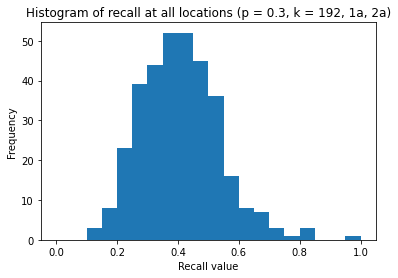

Average recall = 0.40861142866649725


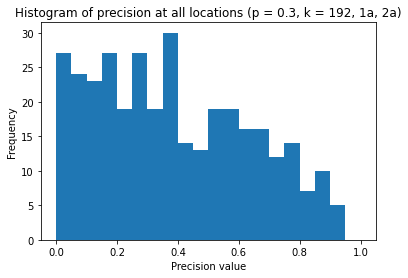

Average precision = 0.3848057184750734

p = 0.35, k = 146

Evaluation metrics


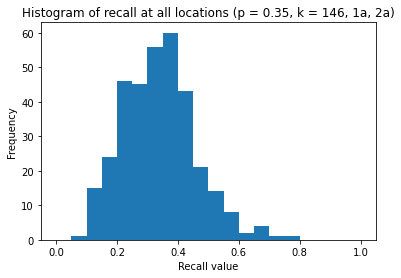

Average recall = 0.338302889143499


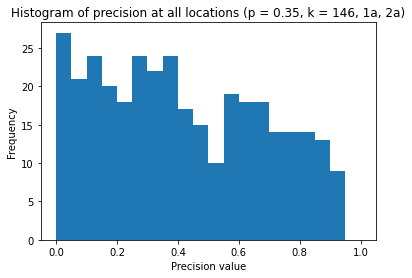

Average precision = 0.41608082593500184

p = 0.4, k = 109

Evaluation metrics


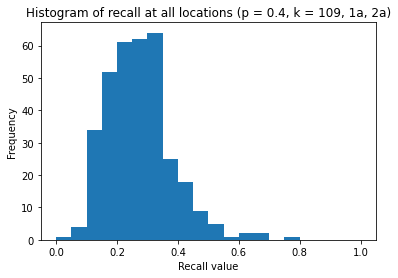

Average recall = 0.27314169896602714


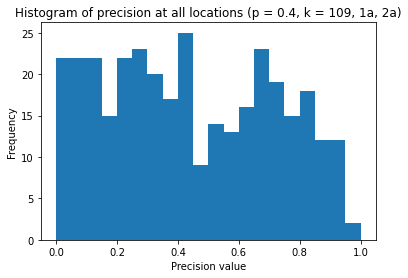

Average precision = 0.4412279049745757

p = 0.45, k = 78

Evaluation metrics


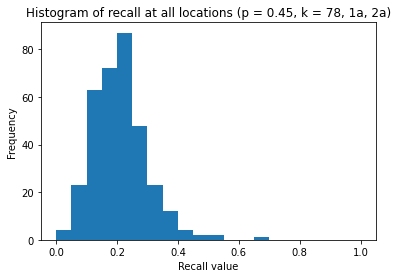

Average recall = 0.2094147730115171


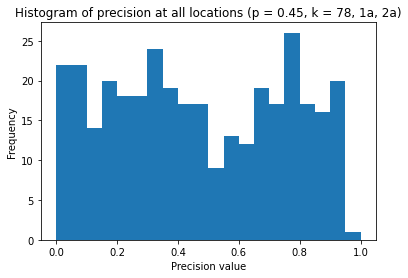

Average precision = 0.4671779833070156


In [21]:
p_range = np.linspace(0.3, 0.45, 4)
k_range = [len(curly_D_p) for curly_D_p in compute_curly_D(p_range, to_print = True).values()]

print("\n\nLocation-based filtering\n")
recalls, precisions = location_based_filter(p_range, k_range, "1a", "2a")



Curly_D recommendations



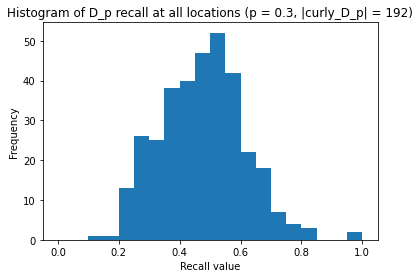

Average recall of recommending D_p = 0.4750802872745034


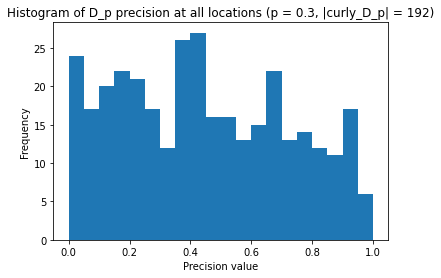

Average precision of recommending D_p = 0.44475500977517124



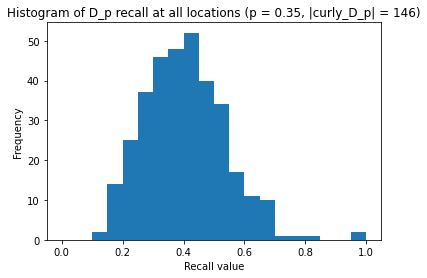

Average recall of recommending D_p = 0.4042038271926573


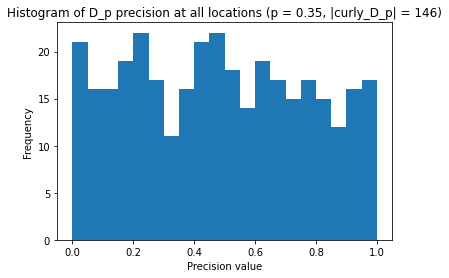

Average precision of recommending D_p = 0.4832683887036521



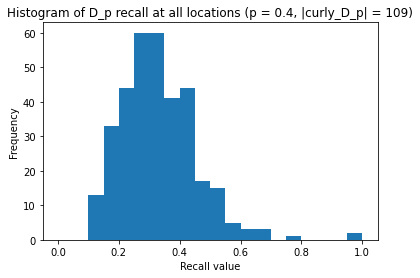

Average recall of recommending D_p = 0.3306152570422653


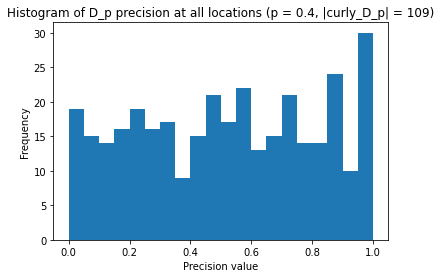

Average precision of recommending D_p = 0.5187656380316934



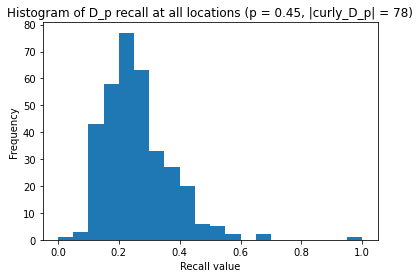

Average recall of recommending D_p = 0.259853851364689


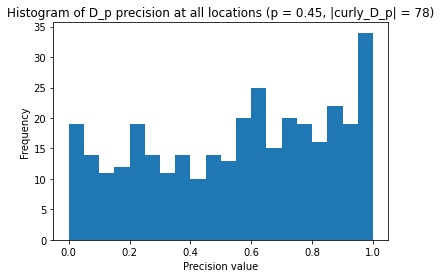

Average precision of recommending D_p = 0.5561320400030079



In [19]:
print("Curly_D recommendations\n")
curly_D_recalls, curly_D_precisions, curly_D = curly_D_alg(p_range)

In [22]:
print("Null recommendations\n")
null_recalls, avg_null_precision = calc_print_null_metrics(k_range)

Null recommendations

Null recall (k = 192) = 0.09815950920245399
Null recall (k = 146) = 0.07464212678936605
Null recall (k = 109) = 0.05572597137014315
Null recall (k = 78) = 0.03987730061349693
Average null precision = 0.10342940587349846
